# Point of Interest Recommendation using Graph Neural Networks

The objective of this work is to implement and train a GNN-based model that will be used for the task of Point of interest (POI) recommendation.

More into the details, the model that I decided to implement is a Graph Convolutional Network (GCN) model that I will train for the task of edge prediction and then I will use to generate POI recommendations.

## Data loading and preparation

### Load data
I will load the data as pandas dataframes in order to simplify the cleaning and preprocessing steps.

First, let's load and import all the dependencies.

In [1]:
from google.colab import drive, userdata
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score
import matplotlib.pyplot as plt
import random
import requests
import time
import ast

In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Linear
torch_version = torch.__version__.split("+")
os.environ["TORCH"] = torch_version[0]
os.environ["CUDA"] = torch_version[1]

In [3]:
%%capture
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import SAGEConv, GATConv, BatchNorm, to_hetero
from torch_geometric.loader import LinkNeighborLoader

In [ ]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 3.1 MB/s eta 0:00:00


I will use google drive to store the data

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Verify the mount
dataset_path = '/content/drive/My Drive/datasets/POIs'

# List the files in the directory
os.listdir(dataset_path)

['Checkins.txt',
 'Cities.txt',
 'POIs.txt',
 'processed',
 'graphs',
 'checkins_df_new.csv',
 'pois_df_new.csv']

In [ ]:
# Read the text files and load them as pandas dfs
checkins_path = os.path.join(dataset_path, 'Checkins.txt')
pois_path = os.path.join(dataset_path, 'POIs.txt')

checkins_df = pd.read_csv(checkins_path, delimiter='\t', header=None, names=['user_id', 'venue_id', 'timestamp', 'Timezone_offset'])
pois_df = pd.read_csv(pois_path, delimiter='\t', header=None, names=['venue_id', 'latitude', 'longitude', 'venue_category_name', 'country_code'])

### Data Exploration
Now I will perform a first data exploration step.

In [ ]:
checkins_df.head()

,user_id,venue_id,timestamp,Timezone_offset
0,50756,4f5e3a72e4b053fd6a4313f6,Tue Apr 03 18:00:06 +0000 2012,240
1,190571,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180
2,221021,4a85b1b3f964a520eefe1fe3,Tue Apr 03 18:00:08 +0000 2012,-240
3,66981,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300
4,21010,4c2b4e8a9a559c74832f0de2,Tue Apr 03 18:00:09 +0000 2012,240


In [ ]:
pois_df.head()

,venue_id,latitude,longitude,venue_category_name,country_code,checkin_count
0,3fd66200f964a52000e71ee3,40.733596,-74.003139,Jazz Club,US,86
4,3fd66200f964a52000ee1ee3,39.933178,-75.159262,Sandwich Place,US,145
7,3fd66200f964a52001e81ee3,40.756353,-73.967676,Bar,US,70
13,3fd66200f964a52002ef1ee3,34.075314,-118.253499,Bar,US,54
15,3fd66200f964a52003e71ee3,40.739685,-74.006020,French Restaurant,US,118


Let's count of many check-ins, POIs and users there are in the dataset.

In [ ]:
# Count the number of samples in each file
print("Number of check-ins:", len(checkins_df))
print("Number of POIs:", len(pois_df))
print("Number of users:", len(checkins_df['user_id'].unique()))

Number of check-ins: 33263633
Number of POIs: 3680126
Number of users: 266909


For now, there is too much data to train a GCN model, so I will need to reduce it.

Let's see if there are missing values.

In [ ]:
# Count missing values in the dataframes
print("Missing values in checkins_df:")
print(checkins_df.isnull().sum())

print("\nMissing values in pois_df:")
print(pois_df.isnull().sum())

Missing values in checkins_df:
user_id            0
venue_id           0
timestamp          0
Timezone_offset    0
dtype: int64

Missing values in pois_df:
venue_id               0
latitude               0
longitude              0
venue_category_name    0
country_code           0
dtype: int64


Apparently, there are no missing values.

Let's now compute some common statistics.

In [ ]:
# Maximum degree (number of connections) for users
maximum_user_degree = checkins_df['user_id'].value_counts().max()

# Maximum degree (number of connections) for POIs
maximum_poi_degree = checkins_df['venue_id'].value_counts().max()

# Minimum degree for users
minimum_user_degree = checkins_df['user_id'].value_counts().min()

# Minimum degree for POIs
minimum_poi_degree = checkins_df['venue_id'].value_counts().min()

# Average degree for users
average_user_degree = checkins_df['user_id'].value_counts().mean()

# Average degree for POIs
average_poi_degree = checkins_df['venue_id'].value_counts().mean()

# Print the results
print("Maximum degree for users:", int(maximum_user_degree))
print("Minimum degree for users:", int(minimum_user_degree))
print("Average degree for users:", int(average_user_degree))
print("Maximum degree for POIs:", int(maximum_poi_degree))
print("Minimum degree for POIs:", int(minimum_poi_degree))
print("Average degree for POIs:", int(average_poi_degree))

Maximum degree for users: 5430
Minimum degree for users: 1
Average degree for users: 124
Maximum degree for POIs: 34509
Minimum degree for POIs: 1
Average degree for POIs: 9


Finally, let's also see how many POI categories there are and how many countries are the POIs from.

In [ ]:
# Count the number of unique country_code values
unique_countries = pois_df['country_code'].nunique()

# Count the number of unique venue_category_name values
unique_categories = pois_df['venue_category_name'].nunique()

# Print the results
print("Number of countries:", unique_countries)
print("Number of POI categories:", unique_categories)

Number of countries: 77
Number of POI categories: 429


### Data Preprocessing and Feature Engineering


Before reducing the dimension of the data, I want to calculate the number of check-ins for each POI and add this information to the POIs dataframe.

In [ ]:
# Calculate number of check-ins in the checkins_df for each POI
poi_checkin_counts = checkins_df['venue_id'].value_counts()

# Add this information to pois_df
pois_df = pois_df.merge(poi_checkin_counts, left_on='venue_id', right_index=True, how='left')
pois_df.rename(columns={'count': 'checkin_count'}, inplace=True)

For now, I decided to reduce the dimension of the data by keeping only the check-ins in USA and removing the users and POIs with less then 50 check-ins registered.

In the future I will probably consider also additional countries.

In [ ]:
# Keep only the checkins and POIs from USA
pois_df = pois_df[pois_df['country_code'] == 'US']
checkins_df = checkins_df[checkins_df['venue_id'].isin(pois_df['venue_id'])]

# Keep only checkins relative to users and POIs with more than 50 checkins
pois_df = pois_df[pois_df['checkin_count'] >= 50]
checkins_df = checkins_df[checkins_df['user_id'].isin(checkins_df['user_id'].value_counts()[checkins_df['user_id'].value_counts() >= 50].index)]

In [ ]:
# Check the number of samples of the filtered dfs
print("Number of filtered check-in samples:", len(checkins_df))
print("Number of filtered POI samples:", len(pois_df))
print("Number of filtered users:", len(checkins_df['user_id'].unique()))

Number of filtered check-in samples: 3194341
Number of filtered POI samples: 10816
Number of filtered users: 22115


In [ ]:
# Save the new dataframes
# checkins_df.to_csv(os.path.join(dataset_path, 'checkins_df_new.csv'), index=False)
# pois_df.to_csv(os.path.join(dataset_path, 'pois_df_new.csv'), index=False)

# Load the new dataframes
checkins_df = pd.read_csv(os.path.join(dataset_path, 'checkins_df_new.csv'))
pois_df = pd.read_csv(os.path.join(dataset_path, 'pois_df_new.csv'))

Because I only have few information about the POIs, I will use the **FourSquare API** to extract additional information.
Specifically, given the venue_id of each POI, I will retrieve the following information:


*   name of the POI
*   city
*   textual description
*   main amenities offered
*   tip count
*   price tier
*   number of likes
*   average rating
*   rating count
*   trending

For the amenities, because they can be a lot, I decided to consider only a subset of them (the most common ones) and define a function to check if a POI offers them. Finally, I will store the amenities offered by each POI as a string.

In [ ]:
# Function to get the most common amenities for each POI (if present)
def filter_common_amenities(attributes, common_amenities):

    possible_values = ['yes', 'true', 'available', 'open', 'music']
    filtered_amenities = set()
    for group in attributes:
        for item in group.get('items', []):
            amenity_name = item.get('displayName', '')
            amenity_value = item.get('displayValue', '')
            # Check if the amenity matches any of the common amenities and if it's present
            if any(common.lower() in amenity_name.lower() for common in common_amenities):
               if any(value.lower() in amenity_value.lower() for value in possible_values):
                  filtered_amenities.add(amenity_name)

    # Format amenities as a single string that I will save in my pois_df.
    amenities = ', '.join(sorted(filtered_amenities)) if filtered_amenities else 'None'
    return amenities

In [ ]:
# Insert Foursquare API credentials
oauth_token= userdata.get('FoursquareToken')
version = '20230804'  # Version of the API

# Define common amenities keywords
common_amenities = [
    'Wi-Fi', 'Parking', 'Restrooms', 'Wheelchair Accessible', 'Outdoor Seating',
    'Pet-Friendly', 'Credit Cards', 'Reservations', 'Smoking Area', 'Air Conditioning',
    'Music'
]

# Function to get all the POIs additional details
def get_venue_details(venue_id):
    url = f"https://api.foursquare.com/v2/venues/{venue_id}/?oauth_token={oauth_token}&v={version}"
    response = requests.get(url)
    if response.status_code == 200:
      venue = response.json().get('response', {}).get('venue', {})
      location = venue.get('location', 'No location available')
      attributes = venue.get('attributes', {}).get('groups', [])

      # Get common amenities
      amenities = filter_common_amenities(attributes, common_amenities)

      venue_info = {
          'venue_id': venue_id,
          'name': venue.get('name', 'No name available'),
          'city': venue.get('location', {}).get('city', 'No city available'),
          'amenities': amenities,
          'tip_count': venue.get('stats', {}).get('tipCount', 0),
          'price_tier': venue.get('price', {}).get('tier', 0),
          'likes': venue.get('likes', {}).get('count', 0),
          'rating': venue.get('rating', 0),
          'rating_count': venue.get('ratingSignals', 0),
          'trending': venue.get('hereNow', {}).get('count', 0)
      }

      return venue_info
    else:
      return f"Error: {response.status_code}"


Because of the rate limits of the Foursquare API, I have decided to download the information in batches and store the intermediate results. Once I have the information for all the POIs, I will add them to the original POIs dataframe through a merge operation.

In [ ]:
# Define batch size and delay
batch_size = 450
delay_between_batches = 3600  # 1 hour in seconds
output_file = '/content/drive/My Drive/datasets/POIs/processed/pois_details.csv'
checkpoint_file = '/content/drive/My Drive/datasets/POIs/processed/pois_checkpoint.csv'

# Initialize the list to collect venue details
venue_details_list = []

# Check if the output file exists to handle appending data
if os.path.exists(output_file):
    # Load existing data
    existing_df = pd.read_csv(output_file)
else:
    # Create an empty DataFrame if the file does not exist
    existing_df = pd.DataFrame()

# Check if a checkpoint file exists
if os.path.exists(checkpoint_file):
    checkpoint_df = pd.read_csv(checkpoint_file)
    processed_poi_ids = set(checkpoint_df['venue_id'])
else:
    checkpoint_df = pd.DataFrame(columns=['venue_id'])
    processed_poi_ids = set()

# Get the list of POI IDs from your DataFrame
poi_ids = pois_df['venue_id']

# Iterate over each POI ID
for i, venue_id in enumerate(poi_ids):
    if venue_id in processed_poi_ids:
        continue  # Skip already processed POIs

    # Get venue info
    venue_info = get_venue_details(venue_id)

    # Check for rate limit
    if venue_info == "Error: 403":
        print(f"Received 'Error: 403' for venue_id {venue_id}. Stopping and saving progress.")
        break  # Exit the loop to save progress without adding this POI

    # Skip POIs with invalid venue_id
    if venue_info == "Error: 400" or venue_info == "Error: 500":
        print(f"Received 'Error: 400' or 'Error: 500' for venue_id {venue_id}.")
        continue

    print(venue_info)  # Print for debugging

    # Add details to the list
    venue_details_list.append(venue_info)

    # Add to checkpoint
    new_checkpoint = pd.DataFrame({'venue_id': [venue_id]})
    checkpoint_df = pd.concat([checkpoint_df, new_checkpoint], ignore_index=True)
    checkpoint_df.to_csv(checkpoint_file, index=False)

    # Check if the batch is complete
    if (i + 1) % batch_size == 0:
        # Convert the list of venue details to a DataFrame
        batch_df = pd.DataFrame(venue_details_list)

        # Append new data to the existing DataFrame
        if not existing_df.empty:
            existing_df = pd.concat([existing_df, batch_df], ignore_index=True)
        else:
            existing_df = batch_df

        # Save the updated DataFrame to a file
        existing_df.to_csv(output_file, index=False)

        # Clear the list for the next batch
        venue_details_list = []

        # Wait before continuing to respect rate limits
        print(f"Processed {i + 1} POIs. Waiting for {delay_between_batches} seconds...")
        time.sleep(delay_between_batches)

# Handle any remaining POIs after the last batch
if venue_details_list:
    batch_df = pd.DataFrame(venue_details_list)
    if not existing_df.empty:
        existing_df = pd.concat([existing_df, batch_df], ignore_index=True)
    else:
        existing_df = batch_df
    existing_df.to_csv(output_file, index=False)

print("Processing complete.")

Received 'Error: 400' or 'Error: 500' for venue_id 4a842e82f964a520dcfb1fe3.
{'venue_id': '5122dfbae4b054242008c7ae', 'name': 'Home', 'city': 'Indianapolis', 'amenities': 'None', 'tip_count': 0, 'price_tier': 0, 'likes': 0, 'rating': 0, 'rating_count': 0, 'trending': 0}
{'venue_id': '512b4c86e4b08ef06fd02468', 'name': 'Ultracolor', 'city': 'Richmond', 'amenities': 'None', 'tip_count': 2, 'price_tier': 0, 'likes': 3, 'rating': 0, 'rating_count': 0, 'trending': 0}
{'venue_id': '512c2cb7e4b045886b6d9de8', 'name': 'Burkland', 'city': 'Bethesda', 'amenities': 'None', 'tip_count': 0, 'price_tier': 0, 'likes': 2, 'rating': 0, 'rating_count': 0, 'trending': 0}
{'venue_id': '5131dd1b526291007b1d5e7e', 'name': 'SxSW 2013', 'city': 'Austin', 'amenities': 'None', 'tip_count': 26, 'price_tier': 0, 'likes': 106, 'rating': 0, 'rating_count': 0, 'trending': 0}
{'venue_id': '5133e834e4b0ed89414dea79', 'name': 'Casa de KRollin & Jakey', 'city': 'South Salt Lake', 'amenities': 'None', 'tip_count': 1, 'pr

In [ ]:
# Define output file path
output_file = '/content/drive/My Drive/datasets/POIs/processed/pois_details.csv'

# Load the dataframe
output_df = pd.read_csv(output_file)

In [ ]:
# There is only 1 POI with invalid user_id, so I will discard it
# Remove from pois_df and checkins_df the POIs not in output_df
pois_df = pois_df[pois_df['venue_id'].isin(output_df['venue_id'])]
checkins_df = checkins_df[checkins_df['venue_id'].isin(output_df['venue_id'])]

In [ ]:
# Merge obtained details into the existing pois_df
pois_df = pd.merge(pois_df, output_df, on='venue_id', how='left')

Now that I have all the information that I need, I have to preprocess the features.

Let's start from the numerical features: I decided to normalize all of them using the **StandardScaler**, except latitude and longitude.
'**price_tier**', which is a categorical feature, is already label encoded.

In [ ]:
# Load the StandardScaler
scaler = StandardScaler()

# Define the numerical features to normalize in the pois_df
pois_numerical_features = ['tip_count', 'likes', 'rating', 'rating_count', 'checkin_count', 'trending']

# Normalize them
pois_df[pois_numerical_features] = scaler.fit_transform(pois_df[pois_numerical_features])

Now I can extract the embeddings for the textual features.

For this task, I decided to use the pretrained **SentenceBERT**, which is very powerful in computing embeddings for natural language texts.
Because the POIs names and descriptions are in different languages, I decided to use the version **paraphrase-multilingual-MiniLM-L12-v2**, which is specifically trained to support multiple languages and provides good performance with relatively small size and fast inference.

In [ ]:
# Define the TextEncoder (SentenceBERT)
class TextEncoder:
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)

    @torch.no_grad()
    def __call__(self, df):
        x = self.model.encode(df, show_progress_bar=True,
                              convert_to_tensor=True, device=self.device)
        return x.cpu()

In [ ]:
# Check if GPU is available and move the model to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = TextEncoder(device=device)

# Textual features to encode
textual_features = ['name', 'city', 'venue_category_name']

# Generate embeddings for each textual feature
name_embeddings = encoder(pois_df['name'].tolist())
venue_category_embeddings = encoder(pois_df['venue_category_name'].tolist())
city_embeddings = encoder(pois_df['city'].tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/338 [00:00<?, ?it/s]

Batches:   0%|          | 0/338 [00:00<?, ?it/s]

Batches:   0%|          | 0/338 [00:00<?, ?it/s]

For the **'country_code'** feature, because it is a categorical feature and not a proper text, I decided to encode it with labels, using the **LabelEncoder**.

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'country_code' column
pois_df['country_code_encoded'] = label_encoder.fit_transform(pois_df['country_code'])

Finally, for the **'amenities'** feature, because I'm considering only the top 10 amenities, which I've represented in a compact format as an ordered string, I decided to encode it as a binary vector of 10 elements, where each element indicates if the corresponding amenity is offered (1) or not (0) by a POI.

In [ ]:
# Function to create multi-hot encoding for amenities
def encode_amenities(amenities_list, all_amenities):
    # Initialize a binary vector of zeros for each POI
    encoding = np.zeros(len(all_amenities), dtype=int)

    # Check if 'None' is in the amenities_list; if so, leave the vector as all zeros
    if pd.isna(amenities_list):
        return encoding

    # Split the amenities string into a list
    amenities_list = amenities_list.split(', ')

    # Iterate over all possible amenities
    for i, amenity in enumerate(all_amenities):
        # Set the corresponding position to 1 if the amenity is present
        if amenity in amenities_list:
            encoding[i] = 1

    return encoding

In [ ]:
# Get all the amenities names
all_amenities = set()
for amenities in pois_df['amenities']:
    if pd.notna(amenities):
        all_amenities.update(amenities.split(', '))

# Apply the multi-hot encoding to the 'amenities' column
pois_df['amenities_encoded'] = pois_df['amenities'].apply(
    lambda x: encode_amenities(x, all_amenities)
)

Now I can combine all the POIs processed features into a final torch tensor, which will be the feature representation for each POI.

In [ ]:
# Combine all the standard features
standard_features = pois_df[['latitude', 'longitude', 'tip_count',
                              'price_tier', 'likes', 'rating', 'rating_count',
                              'checkin_count', 'trending',
                              'country_code_encoded']]
standard_features = np.column_stack(standard_features.values).astype(np.float32).T

# Combine the embeddings of each textual feature
textual_embeddings = np.hstack((name_embeddings, venue_category_embeddings, city_embeddings)).astype(np.float32)

# Handle 'amenities_encoded' separately and convert to float32
amenities_encoded = np.vstack(pois_df['amenities_encoded'].values).astype(np.float32)

# Combine all features into a single numpy array
combined_features = np.hstack([
    standard_features,
    textual_embeddings,
    amenities_encoded
])

# Convert the combined features to a PyTorch tensor
poi_features_tensor = torch.tensor(combined_features, dtype=torch.float32)

As the last step, I have to convert also the **timestamp** feature in the checkins_df in a torch tensor, which I will use as edge features in my graph data later.

In [ ]:
# Extract and reshape the relevant features
timestamps = pd.to_datetime(checkins_df['timestamp']).astype(np.int64) // 10**9  # Convert to seconds
edge_attr_tensor = torch.tensor(timestamps.astype(np.float32), dtype=torch.float32)

<ipython-input-10-7c1d180babe7>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  timestamps = pd.to_datetime(checkins_df['timestamp']).astype(np.int64) // 10**9  # Convert to seconds


Completed the preprocessing steps, I will save the preprocessed dataframes and also the node and edge feature representations.

In [5]:
# Define the save path
dataset_path = '/content/drive/My Drive/datasets/POIs/processed/'
checkins_df_path = os.path.join(dataset_path, 'checkins_df.csv')
pois_df_path = os.path.join(dataset_path, 'pois_df.csv')
features_tensor_path = os.path.join(dataset_path, 'poi_features_tensor.pt')
attr_tensor_path = os.path.join(dataset_path, 'edge_attr_tensor.pt')

In [ ]:
# # Save the preprocessed dataframes and poi_features_tensor and edge_attr_tensor
# checkins_df.to_csv(checkins_df_path, index=False)
# pois_df.to_csv(pois_df_path, index=False)
# torch.save(poi_features_tensor, features_tensor_path)
# torch.save(edge_attr_tensor, attr_tensor_path)

In [6]:
# Load the preprocessed dataframes
checkins_df = pd.read_csv(checkins_df_path)
pois_df = pd.read_csv(pois_df_path)

In [7]:
# Load the node features and edge attributes tensors
poi_features = torch.load(features_tensor_path)
edge_attr = torch.load(attr_tensor_path)

<ipython-input-7-86931ca05aa2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  poi_features = torch.load(features_tensor_path)
<ipython-input-7-86931ca05aa2>:3: FutureWarni

## Build the Graph
Now that I have cleaned, processed and split the dataframes, and obtained the feature and edge representations, I need to create the graph data that I will use to train my GCN-based model.
To handle all the graph computations, I decided to use **PyTorch Geometric**.
In particular, I decided to build an heterogeneous graph with 2 types of nodes (users and POIs) and 3 different types of edges:

*   Edges between users and POIs: a user will be connected to a POI by an edge, if that user has visited that POI.

*   Edges between POIs: two POIs will be connected by an edge, if they have been visited sequentially. The weight of the link will be proportional to the number of times the 2 POIs have been visited sequentially.

*   Edges between users: two users will be connected by an edge, if they have visited POIs in common. The weight of the link will be proportional to the number of common POIs visited.

The edges between POIs will be directed, because I need to keep track of which POI has been visited first between the 2.
The other 2 types of edges will be undirected, in such a way that the model can propagate information in both directions of the edges.

In [ ]:
# Function to create edges between user and POI nodes
def create_user_poi_edges(df, src_index_col, src_mapping, dst_index_col, dst_mapping):

    # Map user and POI indices to integers
    src = [user_mapping[user_id] for user_id in df[src_index_col]]
    dst = [poi_mapping[poi_id] for poi_id in df[dst_index_col]]

    # Combine the source and destination lists into a tensor
    edge_index = torch.tensor([src, dst], dtype=torch.long)

    # Create edge labels (1 for existing edges)
    edge_label = torch.ones(edge_index.size(1), dtype=torch.long)

    return edge_index, edge_label

# Function to create edges between POIs
def create_poi_edges(df, poi_mapping):
    poi_pairs = defaultdict(int)

    # Sort by user and timestamp
    df = df.sort_values(by=['user_id', 'timestamp'])

    for user_id, user_df in df.groupby('user_id'):
        # Take the list of all POIs visited by the user
        pois = user_df['venue_id'].tolist()
        for i in range(len(pois) - 1):
            src_poi = poi_mapping[pois[i]]
            dst_poi = poi_mapping[pois[i+1]]
            # Increment the weight of the edge between 2 POIs, every time they appear sequently
            poi_pairs[(src_poi, dst_poi)] += 1

   # Apply logarithmic transformation to weights, starting at 1
    poi_pairs = {pair: np.log10(1 + weight) for pair, weight in poi_pairs.items()}

    # Convert to tensor format
    couples, weights = zip(*poi_pairs.items())  # Unpack items into separate lists
    src, dst = zip(*couples)  # Unpack source and destination
    edge_index = torch.tensor([src, dst], dtype=torch.long)
    edge_weight = torch.tensor(weights, dtype=torch.float)
    return edge_index, edge_weight

# Function to create edges between users
def create_user_edges(df, user_mapping, poi_mapping):
    user_pairs = defaultdict(int)

    # Group by POI and find users who visited the same POI
    poi_to_users = defaultdict(set)
    for _, row in df.iterrows():
        user_id = user_mapping[row['user_id']]
        poi_id = poi_mapping[row['venue_id']]
        poi_to_users[poi_id].add(user_id)

    # Create user-user pairs
    for users in poi_to_users.values():
        users = list(users)
        for i in range(len(users)):
            for j in range(i + 1, len(users)):
                # Increment the weight logaritmically based on the number of common POIs
                user_pairs[(users[i], users[j])] += np.log10(1 + user_pairs[(users[i], users[j])]) + 1

    # Filter to keep only pairs with at least 1 common POI
    user_pairs = {pair: weight for pair, weight in user_pairs.items() if weight >= 1}

    src, dst, weights = [], [], []
    for (src_user, dst_user), weight in user_pairs.items():
        src.append(src_user)
        dst.append(dst_user)
        weights.append(weight)

    # Build index and weight tensors
    edge_index = torch.tensor([src, dst], dtype=torch.long)
    edge_weight = torch.tensor(weights, dtype=torch.float)

    return edge_index, edge_weight

In [ ]:
# Create users and POIs mappings
poi_mapping = {index: i for i, index in enumerate(pois_df['venue_id'].unique())}
user_mapping = {index: i for i, index in enumerate(checkins_df['user_id'].unique())}

# Create POI-user edges
edge_index, edge_label = create_user_poi_edges(
    checkins_df,
    src_index_col='user_id',
    src_mapping=user_mapping,
    dst_index_col='venue_id',
    dst_mapping=poi_mapping,
)

# Create POI-POI edges
poi_edge_index, poi_edge_weight = create_poi_edges(checkins_df, poi_mapping)

# Create user-user edges
user_edge_index, user_edge_weight = create_user_edges(checkins_df, user_mapping, poi_mapping)

In [ ]:
# Function to create the graph data given the nodes, the edges and the mappings
def create_graph_data(poi_features, user_mapping, poi_mapping, user_poi_edge_index,
                      user_poi_edge_attr, user_poi_edge_label,
                      poi_edge_index, poi_edge_weight,
                      user_edge_index, user_edge_weight):

    data = HeteroData()
    data['user'].node_id = torch.arange(len(user_mapping))
    data['user'].num_nodes = len(user_mapping)
    data['poi'].node_id = torch.arange(len(poi_mapping))
    data['poi'].x = poi_features

    # User-POI edges
    data['user', 'visits', 'poi'].edge_index = user_poi_edge_index
    data['user', 'visits', 'poi'].edge_label = user_poi_edge_label
    data['user', 'visits', 'poi'].edge_attr = user_poi_edge_attr

    # User-User edges
    data['user', 'common_pois', 'user'].edge_index = user_edge_index
    data['user', 'common_pois', 'user'].edge_weight = user_edge_weight

    # Create reverse edge type for User-User edges
    reverse_user_edge_index = user_edge_index[[1, 0]]  # Flip source and destination
    reverse_user_edge_weight = user_edge_weight  # Copy the edge weights

    # Add reverse edges and attributes
    data['user', 'rev_common_pois', 'user'].edge_index = reverse_user_edge_index
    data['user', 'rev_common_pois', 'user'].edge_weight = reverse_user_edge_weight

    # POI-POI edges
    data['poi', 'sequential_visits', 'poi'].edge_index = poi_edge_index
    data['poi', 'sequential_visits', 'poi'].edge_weight = poi_edge_weight

    return data

In [ ]:
# Create the graph data as a HeteroData object
data = create_graph_data(
    poi_features,
    user_mapping,
    poi_mapping,
    edge_index,
    edge_attr,
    edge_label,
    poi_edge_index,
    poi_edge_weight,
    user_edge_index,
    user_edge_weight
)

At this point I can split my graph data into train, validation and test sets.
Because I will train the model for an edge prediction task, I will perform a split based on edges using **RandomLinkSplit**.

In [ ]:
# Save graph data
graph_path = '/content/drive/My Drive/datasets/POIs/graphs/'
graph_path = os.path.join(graph_path, 'graph_data.pt')
# torch.save(data, graph_path)

In [ ]:
# Load graph data
data = torch.load(graph_path)

<ipython-input-10-ccb521886e4a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(graph_path)


In [ ]:
data

HeteroData(
  user={
    node_id=[21835],
    num_nodes=21835,
  },
  poi={
    node_id=[10815],
    x=[10815, 1170],
  },
  (user, visits, poi)={
    edge_index=[2, 1006938],
    edge_label=[1006938],
    edge_attr=[1006938],
  },
  (user, common_pois, user)={
    edge_index=[2, 24149837],
    edge_weight=[24149837],
  },
  (user, rev_common_pois, user)={
    edge_index=[2, 24149837],
    edge_weight=[24149837],
  },
  (poi, sequential_visits, poi)={
    edge_index=[2, 381256],
    edge_weight=[381256],
  }
)

In [ ]:
def temporal_split_edges(data, edge_type, train_ratio=0.7, val_ratio=0.15):
    # Extract edges and timestamps for the specific edge type
    edge_index = data[edge_type].edge_index
    timestamps = data[edge_type].edge_attr

    # Sort by timestamps
    sorted_indices = torch.argsort(timestamps)
    edge_index = edge_index[:, sorted_indices]
    timestamps = timestamps[sorted_indices]

    # Determine split points
    num_edges = edge_index.size(1)
    num_train = int(train_ratio * num_edges)
    num_val = int(val_ratio * num_edges)

    # Split into train, val, test edges
    train_edges = edge_index[:, :num_train]
    val_edges = edge_index[:, num_train:num_train + num_val]
    test_edges = edge_index[:, num_train + num_val:]

    # Create edge attribute splits (timestamps)
    train_timestamps = timestamps[:num_train]
    val_timestamps = timestamps[num_train:num_train + num_val]
    test_timestamps = timestamps[num_train + num_val:]

    return (train_edges, train_timestamps), (val_edges, val_timestamps), (test_edges, test_timestamps)

In [ ]:
# Split the edges between users and POIs
(train_edges, train_timestamps), (val_edges, val_timestamps), (test_edges, test_timestamps) = temporal_split_edges(data, ('user', 'visits', 'poi'))

In [ ]:
train_data = data.clone()
val_data = data.clone()
test_data = data.clone()

# Assign training edges
train_data['user', 'visits', 'poi'].edge_index = train_edges
train_data['user', 'visits', 'poi'].edge_attr = train_timestamps
train_data['user', 'visits', 'poi'].edge_label = torch.ones(train_data['user', 'visits', 'poi'].edge_index.size(1), dtype=torch.long)

# Assign validation edges
val_data['user', 'visits', 'poi'].edge_index = val_edges
val_data['user', 'visits', 'poi'].edge_attr = val_timestamps
val_data['user', 'visits', 'poi'].edge_label = torch.ones(val_data['user', 'visits', 'poi'].edge_index.size(1), dtype=torch.long)

# Assign test edges
test_data['user', 'visits', 'poi'].edge_index = test_edges
test_data['user', 'visits', 'poi'].edge_attr = test_timestamps
test_data['user', 'visits', 'poi'].edge_label = torch.ones(test_data['user', 'visits', 'poi'].edge_index.size(1), dtype=torch.long)

Finally, I will save the graph data in my drive.

In [8]:
# Define the path
graph_path = '/content/drive/My Drive/datasets/POIs/graphs/'
train_path = os.path.join(graph_path, 'train_data.pt')
val_path = os.path.join(graph_path, 'val_data.pt')
test_path = os.path.join(graph_path, 'test_data.pt')

In [ ]:
# Save the graph data
torch.save(train_data, train_path)
torch.save(val_data, val_path)
torch.save(test_data, test_path)

In [9]:
# Load graph data
train_data = torch.load(train_path)
val_data = torch.load(val_path)
test_data = torch.load(test_path)

<ipython-input-9-5e1c0360fd75>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_path)
<ipython-input-9-5e1c0360fd75>:3: FutureWarning: You are 

Before defining and training my model, I need to organize the data in batches. Since I split the data based on edges, I will use **LinkNeighborLoader** to organize the edges of type **user visits poi** (the ones for which I want to make predictions) in batches.

I will also generate 1 negative sample for each positive sample in all the batches. This is necessary because for now, in the graphs, there are only positive samples (i.e. I only have information about the confirmed check-ins) and the model needs also negative samples to learn effectively.

In [10]:
# Create the LinkNeighborLoader for training data
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[15, 5, 10, 5],  # Number of neighbors for each layer
    edge_label = train_data['user', 'visits', 'poi'].edge_label,
    edge_label_index=(('user', 'visits', 'poi'), train_data['user', 'visits', 'poi'].edge_index),  # Type of edge based on which aggregate neighbors
    batch_size=512,
    shuffle=True,
    neg_sampling="binary"  # Add to the batch a number of negative samples equal to batch_size
)

# Create the LinkNeighborLoader for validation data
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[15, 5, 10, 5],
    edge_label = val_data['user', 'visits', 'poi'].edge_label,
    edge_label_index=(('user', 'visits', 'poi'), val_data['user', 'visits', 'poi'].edge_index),
    batch_size=512,
    shuffle=False,
    neg_sampling="binary"
)

# Create the LinkNeighborLoader for test data
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[15, 5, 10, 5],
    edge_label = test_data['user', 'visits', 'poi'].edge_label,
    edge_label_index=(('user', 'visits', 'poi'), test_data['user', 'visits', 'poi'].edge_index),
    batch_size=512,
    shuffle=False,
    neg_sampling="binary"
)

## Graph Convolutional Network (GCN)

### Model implementation
At this point, I need to define and implement the model that I will train for the task of edge prediction and then I will use for POIs Recommendation.

In particular, it will be composed by the following components:

1.   A module with 4 Linear layers, used to map the POIs features and the edge attributes and weights of the 3 types of edges to the dimension of the GNN layers.
2.   An embedding layer, to learn embeddings for the users, for which I don’t have any feature.
3.   A GNN module, composed by 2 couples of SAGEConv and GATConv layers, that takes in input the nodes embeddings and edge attributes and learns new nodes embeddings. The first 3 layers are followed by a ReLu function, a BatchNorm layer and a Dropout layer.
4.   A final MLP classifier module, composed by 3 Linear layers with ReLu functions, followed by a softmax function, that takes in input the updated nodes embeddings and predicts probabilities for the edges between users and POIs.

In [12]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_attr_dim, heads=4, dropout=0.3):
        super().__init__()
        # First SAGEConv layer
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.norm1 = BatchNorm(hidden_channels)
        # First Attention layer
        self.attn1 = GATConv(hidden_channels, hidden_channels, heads=heads, concat=False, edge_dim=edge_attr_dim, add_self_loops=False)
        self.norm2 = BatchNorm(hidden_channels)
        # Second SAGEConv layer
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.norm3 = BatchNorm(hidden_channels)
        # Second Attention layer
        self.attn2 = GATConv(hidden_channels, out_channels, heads=heads, concat=False, edge_dim=edge_attr_dim, add_self_loops=False)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr):
        # SAGEConv Layer 1 with normalization and dropout
        x = self.conv1(x, edge_index).relu()
        x = self.norm1(x)
        x = self.dropout(x)

        # GAT Layer 1 with normalization and dropout
        x = self.attn1(x, edge_index, edge_attr=edge_attr).relu()
        x = self.norm2(x)
        x = self.dropout(x)

        # SAGEConv Layer 2 with normalization and dropout
        x = self.conv2(x, edge_index).relu()
        x = self.norm3(x)
        x = self.dropout(x)

        # GAT Layer 2
        x = self.attn2(x, edge_index, edge_attr=edge_attr)

        return x

In [13]:
class MLPClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2):  # Output_dim is 2 for binary classification
        super().__init__()
        self.fc1 = Linear(input_dim, hidden_dim)
        self.fc2 = Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = Linear(hidden_dim // 2, output_dim)

    def forward(self, x_user, x_poi, edge_label_index):
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_poi = x_poi[edge_label_index[1]]

        # Combine node embeddings (Concatenation in this case)
        edge_feat = torch.cat([edge_feat_user, edge_feat_poi], dim=-1)

        # Pass through MLP layers
        x = F.relu(self.fc1(edge_feat))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Raw scores for both classes

        # Apply softmax to get probabilities
        return F.softmax(x, dim=-1)

In [14]:
class POIRecommender(torch.nn.Module):
    def __init__(self, hidden_channels, poi_features_dim, edge_features_dim, hidden_dim=64, heads=4, dropout=0.3):
        super().__init__()
        # Linear layers to map poi features, edge features and edge weights to hidden_channels dimension
        self.map_lin = torch.nn.ModuleDict({
            'poi_features': torch.nn.Linear(poi_features_dim, hidden_channels),
            'user_poi_attr': torch.nn.Linear(edge_features_dim['user_visits_poi'], hidden_channels),
            'poi_poi_attr': torch.nn.Linear(edge_features_dim['poi_sequential_visits_poi'], hidden_channels),
            'user_user_attr': torch.nn.Linear(edge_features_dim['user_common_pois_user'], hidden_channels)
        })
        # Embedding layer to learn user embeddings with hidden_channels dimension
        self.user_emb = torch.nn.Embedding(train_data["user"].num_nodes, hidden_channels)
        # GNN module to update nodes embeddings
        self.gnn = GNN(hidden_channels, hidden_channels, hidden_channels, edge_attr_dim=hidden_channels, heads=heads, dropout=dropout)
        self.gnn = to_hetero(self.gnn, metadata=train_data.metadata())
        # MLP classifier takes concatenated user-poi embeddings, so input_dim = 2 * hidden_channels
        self.classifier = MLPClassifier(input_dim=2 * hidden_channels, hidden_dim=hidden_dim)

    def forward(self, data):
        # Initialize embeddings for users and POIs
        x_dict = {
            "user": self.user_emb(data["user"].n_id),
            "poi": self.map_lin['poi_features'](data["poi"].x),
        }

        # Get edge attributes and build a dictionary
        edge_attr_user_poi = data['user', 'visits', 'poi'].edge_attr.view(-1,1)
        edge_weight_poi_poi = data['poi', 'sequential_visits', 'poi'].edge_weight.view(-1,1)
        edge_weight_user_user = data['user', 'common_pois', 'user'].edge_weight.view(-1,1)
        edge_weight_user_user_rev = data['user', 'rev_common_pois', 'user'].edge_weight.view(-1,1)

        edge_attr_dict = {
            ('user', 'visits', 'poi'): self.map_lin['user_poi_attr'](edge_attr_user_poi),
            ('user', 'common_pois', 'user'): self.map_lin['user_user_attr'](edge_weight_user_user),
            ('user', 'rev_common_pois', 'user'): self.map_lin['user_user_attr'](edge_weight_user_user_rev),
            ('poi', 'sequential_visits', 'poi'): self.map_lin['poi_poi_attr'](edge_weight_poi_poi)
        }

        # Obtain node embeddings using the GNN
        x_dict = self.gnn(x_dict, data.edge_index_dict, edge_attr_dict)

        # Use the MLP classifier to predict link probabilities
        pred = self.classifier(
            x_dict["user"],
            x_dict["poi"],
            data["user", "visits", "poi"].edge_label_index,
        )

        return pred

In [15]:
# Define dimensions of edge attributes
edge_features_dim = {
    'user_visits_poi': train_data['user', 'visits', 'poi'].edge_attr.view(-1,1).size(-1),
    'poi_sequential_visits_poi': train_data['poi', 'sequential_visits', 'poi'].edge_weight.view(-1,1).size(-1),
    'user_common_pois_user': train_data['user', 'common_pois', 'user'].edge_weight.view(-1,1).size(-1)
}

# Define dimensions of poi features
poi_features_dim=train_data['poi'].x.size(-1)

In [16]:
# Define the model and attach it to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = POIRecommender(hidden_channels=64, poi_features_dim=poi_features_dim, edge_features_dim=edge_features_dim)
model = model.to(device)
print(model)

POIRecommender(
  (map_lin): ModuleDict(
    (poi_features): Linear(in_features=1170, out_features=64, bias=True)
    (user_poi_attr): Linear(in_features=1, out_features=64, bias=True)
    (poi_poi_attr): Linear(in_features=1, out_features=64, bias=True)
    (user_user_attr): Linear(in_features=1, out_features=64, bias=True)
  )
  (user_emb): Embedding(21835, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__visits__poi): SAGEConv(64, 64, aggr=mean)
      (user__common_pois__user): SAGEConv(64, 64, aggr=mean)
      (user__rev_common_pois__user): SAGEConv(64, 64, aggr=mean)
      (poi__sequential_visits__poi): SAGEConv(64, 64, aggr=mean)
    )
    (norm1): ModuleDict(
      (user): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (poi): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dropout): ModuleDict(
      (user): Dropout(p=0.3, inplace=False)
      (poi): Dropout(p=0.3, inplace=False)
    )
 

### Training and Validation

At this point, I can finally define the train and validation cycles and train my model.

In [ ]:
# Implement train cycle
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch["user", "visits", "poi"].edge_label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

To evaluate the performance of my model on the validation set, I've decided to use as metrics, **accuracy**, **f1-score**, **roc-auc-score** and **average-precision**.

In [ ]:
# Implement validation cycle
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)

            # Calculate loss
            loss = criterion(out, batch["user", "visits", "poi"].edge_label)
            total_loss += loss.item()

            # Get the predicted class
            pred_classes = np.argmax(out.cpu().numpy(), axis=1)

            # Get the true labels
            labels = batch["user", "visits", "poi"].edge_label.cpu().numpy()

            # Store predictions and labels
            all_preds.append(pred_classes)
            all_labels.append(labels)

            # Store the probabilities for the positive class
            probs = out[:, 1].cpu().numpy()
            all_probs.append(probs)

    avg_loss = total_loss / len(loader)

    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='binary')  # 'binary' for binary classification

    # Calculate roc_auc_score
    roc_auc = roc_auc_score(all_labels, all_probs)

    # Calculate average_precision_score
    average_precision = average_precision_score(all_labels, all_probs)

    return avg_loss, accuracy, f1, roc_auc, average_precision

Finally, I will implement a function that incorporates both train and validation cycles with **EarlyStopping**.

In [17]:
# Define save path to save the best model
path = '/content/drive/My Drive/datasets/POIs/graphs/'
model_name = 'model.pth'
model_path = os.path.join(path, model_name)

# Define function for training and validation with early-stopping
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    accuracy_scores = []
    f1_scores = []
    roc_auc_scores = []
    average_precision_scores = []

    for epoch in range(num_epochs):
        # Training step
        train_loss = train(model, train_loader, optimizer, criterion)

        # Validation step
        val_loss, accuracy, f1, roc_auc, average_precision = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)
        average_precision_scores.append(average_precision)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}, '
              f'Validation F1: {f1:.4f}, Validation ROC-AUC: {roc_auc:.4f}, '
              f'Validation Average Precision: {average_precision:.4f}')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            torch.save(model.state_dict(), model_path)  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    # Load the best model
    model.load_state_dict(torch.load(model_path))
    return model, train_losses, val_losses, accuracy_scores, f1_scores, roc_auc_scores, average_precision_scores

Let's train the model.

In [ ]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Define number of epochs to train the model
epochs = 30

# Train and validate the model
best_model, train_losses, val_losses, accuracy_scores, f1_scores, roc_auc_scores, average_precision_scores  = train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=epochs)

Epoch 1/30, Train Loss: 0.5748, Validation Loss: 0.5230, Validation Accuracy: 0.7799, Validation F1: 0.7732, Validation ROC-AUC: 0.8459, Validation Average Precision: 0.8173
Epoch 2/30, Train Loss: 0.5086, Validation Loss: 0.4664, Validation Accuracy: 0.8361, Validation F1: 0.8488, Validation ROC-AUC: 0.9251, Validation Average Precision: 0.9148
Epoch 3/30, Train Loss: 0.4698, Validation Loss: 0.4499, Validation Accuracy: 0.8546, Validation F1: 0.8622, Validation ROC-AUC: 0.9373, Validation Average Precision: 0.9335
Epoch 4/30, Train Loss: 0.4562, Validation Loss: 0.4443, Validation Accuracy: 0.8607, Validation F1: 0.8666, Validation ROC-AUC: 0.9393, Validation Average Precision: 0.9341
Epoch 5/30, Train Loss: 0.4430, Validation Loss: 0.4294, Validation Accuracy: 0.8774, Validation F1: 0.8816, Validation ROC-AUC: 0.9503, Validation Average Precision: 0.9457
Epoch 6/30, Train Loss: 0.4303, Validation Loss: 0.4289, Validation Accuracy: 0.8788, Validation F1: 0.8821, Validation ROC-AUC: 0

<ipython-input-18-6f821b1bfc42>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [ ]:
# Plot train loss and validation loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

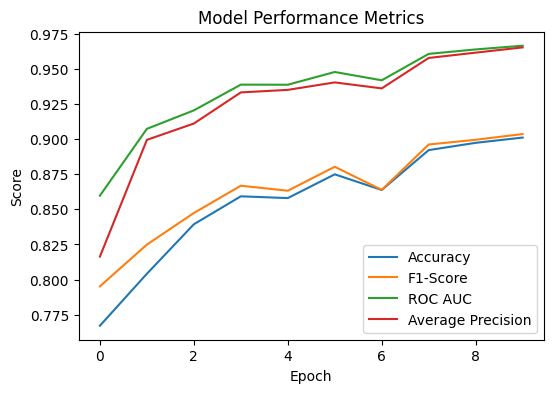

In [ ]:
# Create a plot with accuracy, f1-score, roc-auc-score and average-precision curves
plt.figure(figsize=(6, 4))
plt.plot(accuracy_scores, label='Accuracy')
plt.plot(f1_scores, label='F1-Score')
plt.plot(roc_auc_scores, label='ROC AUC')
plt.plot(average_precision_scores, label='Average Precision')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Model Performance Metrics')
plt.show()

### Test and Itinerary Recommendation

Now I will evaluate the performance of my model in predicting the edges in the test set.

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_f1, test_roc_auc, test_average_precision = evaluate(best_model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1: {test_f1:.4f}')
print(f'Test ROC-AUC: {test_roc_auc:.4f}')
print(f'Test Average Precision: {test_average_precision:.4f}')

Test Loss: 0.4093
Test Accuracy: 0.8984
Test F1: 0.9010
Test ROC-AUC: 0.9652
Test Average Precision: 0.9643


Finally, I can use the trained model to generate POIs recommendations to build an itinerary for a given user.

In particular, I will:

1.   Use the GNN module to compute embeddings for all users and POIs.
2.   Choose a specific user and pick its embedding.
3.   Use the classifier module to output the edge between the user and the most probable POI, which will be the recommendation.


In [18]:
# Load the saved best model from drive and attach to gpu
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model = model.to(device)

<ipython-input-18-f79117b36ad2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


Let's compute the representations for all users and POIs in the test data.

In [19]:
# Initialize containers for x_dict
num_users = test_data['user'].node_id.size(0)  # Total number of users
num_pois = test_data['poi'].x.size(0)   # Total number of POIs

# Create empty tensors for embeddings
user_embeddings = torch.zeros((num_users, 64), device=device)  # Adjust dimensions as needed
poi_embeddings = torch.zeros((num_pois, 64), device=device)

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for batch in test_loader:
        # Move batch data to the appropriate device (if necessary)
        batch = batch.to(device)

        # Compute initial embeddings for the batch
        batch_user_embeddings = model.user_emb(batch['user'].n_id)
        batch_poi_embeddings = model.map_lin['poi_features'](batch['poi'].x)

        # Define x_dict for this batch
        x_dict_batch = {'user': batch_user_embeddings, 'poi': batch_poi_embeddings}

        # Get edge attributes and build a dictionary
        edge_attr_user_poi = batch['user', 'visits', 'poi'].edge_attr.view(-1,1)
        edge_weight_poi_poi = batch['poi', 'sequential_visits', 'poi'].edge_weight.view(-1,1)
        edge_weight_user_user = batch['user', 'common_pois', 'user'].edge_weight.view(-1,1)
        edge_weight_user_user_rev = batch['user', 'rev_common_pois', 'user'].edge_weight.view(-1,1)

        # Get edge attributes and build edge_attr_dict for this batch
        edge_attr_dict = {
            ('user', 'visits', 'poi'): model.map_lin['user_poi_attr'](edge_attr_user_poi),
            ('user', 'common_pois', 'user'): model.map_lin['user_user_attr'](edge_weight_user_user),
            ('user', 'rev_common_pois', 'user'): model.map_lin['user_user_attr'](edge_weight_user_user_rev),
            ('poi', 'sequential_visits', 'poi'): model.map_lin['poi_poi_attr'](edge_weight_poi_poi)
        }

        # Pass through the GNN to get updated embeddings
        x_dict_batch = model.gnn(x_dict_batch, batch.edge_index_dict, edge_attr_dict)

         # Update the global user and POI embeddings using node IDs in the batch
        user_batch_indices = batch.n_id_dict['user']
        poi_batch_indices = batch.n_id_dict['poi']
        user_embeddings[user_batch_indices] = x_dict_batch['user']
        poi_embeddings[poi_batch_indices] = x_dict_batch['poi']

# Recreate x_dict with updated embeddings
x_dict = {'user': user_embeddings, 'poi': poi_embeddings}

In [20]:
# Function to recommend a POI or an itinerary of POIs
def recommend_poi(user_id, pois_df, top_k=3, itinerary=False):

  # Get the embedding of the specified user and of all the pois, along with the venue ids
  user_embedding = x_dict['user'][user_id].unsqueeze(0)
  poi_embeddings = x_dict['poi']
  poi_indices = [poi_mapping[venue_id] for venue_id in pois_df['venue_id'].values if venue_id in poi_mapping]
  poi_embeddings = poi_embeddings[poi_indices]
  # Replicate the user embedding to match the number of POIs
  user_embeddings_repeated = user_embedding.repeat(poi_embeddings.size(0), 1)

  # Concatenate user and POI embeddings to form input for the classifier
  edge_features = torch.cat([user_embeddings_repeated, poi_embeddings], dim=-1)

  # Compute scores for all POIs using the trained MLP classifier
  with torch.no_grad():
        scores = model.classifier.fc1(edge_features).relu()
        scores = model.classifier.fc2(scores).relu()
        scores = model.classifier.fc3(scores)

  # Get the scores for class "1" (positive class)
  positive_scores = scores[:, 1]

  # Get the top-k POIs with the highest scores
  top_k_indices = torch.topk(positive_scores, top_k).indices

  top_k_poi_ids = [poi_indices[idx] for idx in top_k_indices.tolist()]

  if itinerary:
    return top_k_poi_ids

  # Randomly choose of of the top-k pois to recommend
  top_k_poi_id = random.choice(top_k_poi_ids)

  return top_k_poi_id

In [34]:
# Function to display information for a single POI
def display_poi_info(poi, prefix="POI"):
    # Revert back to the original index
    poi_id = poi_mapping_inv[poi]
    # Get POI details
    poi_name = pois_df[pois_df['venue_id'] == poi_id]['name'].values[0]
    poi_category = pois_df[pois_df['venue_id'] == poi_id]['venue_category_name'].values[0]
    poi_city = pois_df[pois_df['venue_id'] == poi_id]['city'].values[0]
    # Print information with the appropriate prefix
    print(f"{prefix}: {poi_name} ({poi_category}) in {poi_city}")

# Function to display an itinerary of POIs
def display_itinerary(pois):
    for idx, poi in enumerate(pois, start=1):
        prefix = f"POI {idx}"
        display_poi_info(poi, prefix=prefix)

In [22]:
# Create users and POIs mappings to convert ids into integers
user_mapping = {index: i for i, index in enumerate(checkins_df['user_id'].unique())}
user_mapping_inv = {v: k for k, v in user_mapping.items()}
poi_mapping = {index: i for i, index in enumerate(pois_df['venue_id'].unique())}
poi_mapping_inv = {v: k for k, v in poi_mapping.items()}

Let's try to make a recommendation. In particular, for how I defined the recommendation function, I can choice to recommend a single POI, or also an itinerary of POIs. Let's try with an itinerary.

In [35]:
# Choice 3 random users from the test data
user_ids = random.sample((test_data['user'].node_id.unique().tolist()), 3)
# Recommend an itinerary of POIs
for user_id in user_ids:
  recommended_pois = recommend_poi(user_id, pois_df, top_k=3, itinerary=True)
  # Show POI details
  print(f"Itinerary for user {user_id}:")
  display_itinerary(recommended_pois)

Itinerary for user 2302:
POI 1: BSI Exhibits (Office) in Garnet Valley
POI 2: Quail Ridge Apartments (Home (private)) in Raleigh
POI 3: The Casa (Home (private)) in Galena Park
Itinerary for user 3790:
POI 1: Paradise Rock Club (Rock Club) in Boston
POI 2: Memphis International Airport (MEM) (Airport) in Memphis
POI 3: Starbucks (Coffee Shop) in Burlington
Itinerary for user 18704:
POI 1: Stericycle (Building) in Baltimore
POI 2: thomas' home (Home (private)) in No city available
POI 3: Greenbelt Yard (Government Building) in Greenbelt


As it is possible to notice, the model is able to generate recommendations

At this point, I can also implement some constraints that I can use to guide the recommendation process; in particular, I decided to implement 3 types of constraints: **city**, **category** and **distance**. I have decided to implement a new function that filters the pois_df based on the constraints and then calls recommend_poi function passing the filtered df.

In [24]:
def recommend_with_constraints(user_id, pois_df, constraints, top_k=3, itinerary=False):

  # Check if the various constraints are set
  if constraints['city'] is not None:
    pois_df = pois_df[pois_df['city'] == constraints['city']]
  if constraints['categories'] is not None:
    pois_df = pois_df[pois_df['venue_category_name'].str.contains('|'.join(constraints['categories']))]
  if constraints['user_location'] is not None and constraints['distance'] is not None:
    lat, lon = constraints['user_location']
    distance = constraints['distance']
    pois_df = pois_df[pois_df.apply(lambda row: compute_distance(lat, lon, row['latitude'], row['longitude']), axis=1) <= distance]

  # Recommend a poi or an itinerary of pois belonging to the filtered df
  return recommend_poi(user_id, pois_df, top_k, itinerary)

In [25]:
# Function to compute distance between 2 locations, given lat and long
def compute_distance(lat1, lon1, lat2, lon2):

  # Convert degrees to radians
  lat1 = np.radians(lat1)
  lon1 = np.radians(lon1)
  lat2 = np.radians(lat2)
  lon2 = np.radians(lon2)

  # Haversine formula
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
  radius_of_earth = 6371  # Radius of the Earth in kilometers
  distance = radius_of_earth * c

  return distance

Now, let's try to generate recommendations with the city constraint.

In [26]:
# Define constraints
constraints = {
    'city': 'New York',
    'categories': None,
    'user_location': None,
    'distance': None
}

In [27]:
# Generate an itinerary of 5 POIs in New York City
recommended_itinerary = recommend_with_constraints(user_id, pois_df, constraints, top_k=5, itinerary=True)
display_itinerary(recommended_itinerary)

POI: The Halal Guys (Food Truck) in New York
POI: Museum of Sex (Museum) in New York
POI: The Bean (Coffee Shop) in New York
POI: Chelsea Market (Market) in New York
POI: Industry Bar (Gay Bar) in New York


Now let's also try to impose a distance constraint: in particular, I will take as representatives of the user current position, the latitude and longitude of the last visited POI.

In [28]:
# Take a random user
user_id = random.choice(user_ids)

# Define max distance
distance = 50.0

# Take the last POI visited by the user from the checkins_df
last_poi_visited = checkins_df[checkins_df['user_id'] == user_mapping_inv[user_id]]['venue_id'].values[-1]

# Get latitude and longitude of the POI from the pois_df
last_poi_lat = pois_df[pois_df['venue_id'] == last_poi_visited]['latitude'].values[0]
last_poi_lon = pois_df[pois_df['venue_id'] == last_poi_visited]['longitude'].values[0]

# Define constraints
constraints = {
    'city': None,
    'categories': None,
    'user_location': (last_poi_lat, last_poi_lon),
    'distance': distance
}

In [29]:
# Generate an itinerary of 3 POIs with distance from the position of the last POI visited <= max_distance
recommended_itinerary = recommend_with_constraints(user_id, pois_df, constraints, top_k=5, itinerary=True)
display_itinerary(recommended_itinerary)

POI: Technology Support Center (College Technology Building) in Atlanta
POI: Syscom Technologies (Office) in Marietta
POI: Interstate 20 (Road) in Atlanta
POI: Allure at Brookwood (Residential Building (Apartment / Condo)) in Atlanta
POI: MARTA - Lindbergh Center Station (Light Rail) in Atlanta


Now, let's try to use the category constraint.

In [30]:
# Define constraints
constraints = {
    'city': None,
    'categories': ['Park'],
    'user_location': None,
    'distance': None
}

In [31]:
# Generate an itinerary of 5 POIs with category 'Park'
recommended_itinerary = recommend_with_constraints(user_id, pois_df, constraints, top_k=5, itinerary=True)
display_itinerary(recommended_itinerary)

POI: Loring Park (Park) in Minneapolis
POI: Centennial Olympic Park (Park) in Atlanta
POI: Stone Mountain Park (Park) in Stone Mountain
POI: Turner Field - Blue Lot (Parking) in Atlanta
POI: Piedmont Park (Park) in Atlanta


Finally, let's try to combine 2 constraints togheter, like city and category, specifying in this case multiple categories.

In [32]:
# Define constraints
constraints = {
    'city': 'New York',
    'categories': ['Museum', 'History', 'Art'],
    'user_location': None,
    'distance': None
}

In [33]:
# Generate an itinerary of 5 POIs with city and category constraints
recommended_itinerary = recommend_with_constraints(user_id, pois_df, constraints, top_k=5, itinerary=True)
display_itinerary(recommended_itinerary)

POI: Metropolitan Museum of Art (Art Museum) in New York
POI: Museum of Modern Art (MoMA) (Art Museum) in New York
POI: TODAY Show (Performing Arts Venue) in New York
POI: Whitney Museum of American Art (Art Museum) in New York
POI: Solomon R. Guggenheim Museum (Art Museum) in New York


## Conclusions
As it is possible to see from the above experiments, the model in general is able to generate useful recommendations for possible itineraries, especially when imposing the constraints. It should also be noticed that the recommendations are not perfect, but I have only trained my model for 30 epochs because of the time needed. So, it is very likely that, in the future, with the correct adjustments, my model could become a very good model, able to generate very useul recommendations. Despite all of this, I think that my model, at the current time, is quite good at recommending possible travel itineraries.